In [1]:
%pylab inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import re
from itertools import permutations, combinations, compress
import os
from scipy.signal import find_peaks, peak_prominences
from ipywidgets import *
from sklearn.cluster import KMeans

from chart_studio import plotly
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
from scipy.optimize import curve_fit
from scipy.signal import peak_widths

from sklearn import preprocessing
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.tree import DecisionTreeClassifier, plot_tree

from IPython.display import clear_output


Populating the interactive namespace from numpy and matplotlib


In [ ]:
'''
ossz_kombok = []
for N in range(2,11):
    faults = array([f'{i}b' for i in range(1,N)])
    perms = []
    kombok = []
    for i in range(int(np.ceil(N/2))):
        for perm in sorted(set(permutations(np.concatenate((-1*np.ones(i),np.ones(N-1-i)))))):
            if list(perm)[::-1] not in perms and list(-1*np.array(perm)) not in perms:
                perms.append(list(perm))
                kombok.append((faults[np.array(perm) == -1]).tolist())
    ossz_kombok.append(kombok)
'''

In [ ]:
#len(ossz_kombok),len(faultok_list)

In [2]:
a0 = 1; #length of unit cell vector.
a1 = a0/2*np.array([np.sqrt(3), 1, 0]);
a2 = a0/2*np.array([np.sqrt(3),-1, 0]);
a3 = a0/2*np.array([0 ,0, 1]);

#reciprocal lattice vectors:
b1 = 2*np.pi/a0*np.matrix([1/np.sqrt(3),1]);
b2 = 2*np.pi/a0*np.matrix([1/np.sqrt(3),-1]);
a_cc = a0/np.sqrt(3); #carbon-carbon distance

def chain_maker(N,in_list,suly=[]):
    '''Ez a függvényecske egy ábrázoló rutin. Vár két bemenő paramétert, egy N számot, ami azt jelenti, hogy hány darab réteg legyen és egy in_list-et, amiben meg ott van benne, hogy hol legyenek a törések.
    Fontos, hogy kétféle törés elképzelhető, a Bernal-fault és a T-hiba. Valahogy ki kéne találni valami intelligens eljárást arra, hogy ezt könveljük. Mivel a bernal hiba és a T hiba is végeredményben ugyan
    azzal jár, lehet hogy csak már egy map-et fogok kérni. Mivel előreláthatólag csak én fogom használni ezt a rutint nincs is nagy jelentősége... Legyen akkor így, az input lista kicsit körülményes tud majd lenni, 
    legfeljebb később ezt majd módosítom.
    Jelenleg úgy működik, hogy vár egy t vagy b karaktert, annak megfelelően, hogy milyen a hiba, aztán egy számot, hogy hányadik sorban legyen a hiba. '1t' azt jelenti, hogy az első réteg után kövekezik egy t hiba. stb.
    '''
    if len(suly) == 0:
        suly = 50*np.ones((2*N,1)) #amikor ábrázolom, mekkorák legyenek a szén atomokon lévő, valószínűségabszolútérték felhők, amik ugye arányban állnak azzal, hogy mekkora a sűrűség egy adott site-on. A suly itt azt jelenti, hogy kezdetben ez egy.
    #először tehát hozzuk létre a láncot! Kell egy array, aminek két oszlopa van, az x és y koordinátája a szénatomoknak. 
    x_cords = np.array([0]+list(np.kron(np.arange(1,N+1),[1,1])))[0:N*2] 
    y_cords = np.kron(range(N),[1,1])

    #kössük össze

    plt.axis('equal')            
    # jöhetnek a törések. Ha törés van, akkor eggyel eltoljuk a szénatomokat balra. Először ki kell találni hogyan töltöm fel a
    # törések között a cuccokat...
    #volt már T tipusu hiba? Elsőként biztos nem
    flag_T = False
    if (in_list == ['']):
        in_list = []
    for string in in_list:
        helyzet = (int(re.search(r'\d+', string).group())) #kiszedjük, hogy melyik rétegre gondolt a költő
        if ('b' in string or 'B' in string) and flag_T==False:   #ha bernal-ra, de még nem volt T hiba, akkor balra kell visszahúzni, ezért vonunk ki 2-t
            x_cords[helyzet*2:]=x_cords[helyzet*2:]-2
        if ('b' in string or 'B' in string) and flag_T==True:   #ha bernal a hiba de már volt korábban T hiba akkor jobbra kell lépni
            x_cords[helyzet*2:]=x_cords[helyzet*2:]+2 
            
        if ('t' in string or 'T' in string):  #ha T hiba akkor simán tükrözni kell
            x_cords[helyzet*2:]=2*np.mean([x_cords[helyzet*2-2],x_cords[helyzet*2-1]])-x_cords[helyzet*2:]
            flag_T = not(flag_T)
        
    #ez itten már csak plottolásiból van
    plt.scatter(x_cords,y_cords,s=suly);
    for i in range(len(x_cords)):
        for j in range(len(x_cords)):
            if np.linalg.norm(np.array([x_cords[i],y_cords[i]])-np.array([x_cords[j],y_cords[j]])) < 1.1:
                plt.plot([x_cords[i],x_cords[j]],[y_cords[j],y_cords[i]],'k'); #összeköttetés
    #plt.xlabel(r'X Position [$a_0$]')
    #plt.ylabel(r'Y Position [$a_0$]')
    
                
    #plt.grid()
    xticks(ticks=[])
    yticks(ticks=[])
    return a0/np.sqrt(3)*x_cords,y_cords, #itt írtál egy d szorzót az y-ra az nem volt definiálva


In [ ]:
fig,axs = subplots(1,4,figsize=(20,5))
fig.subplots_adjust(wspace=0)
subplot(1,4,1)
x_cords, y_cords = chain_maker(10,['2b','4b','6b'])
subplot(1,4,2)
x_cords, y_cords = chain_maker(5,[])
subplot(1,4,3)
x_cords, y_cords = chain_maker(8,[])
subplot(1,4,4)
x_cords, y_cords = chain_maker(10,[])



In [ ]:
figure(figsize=(5,5))
x_cords, y_cords = chain_maker(10,['3b','5b','7b','9b'])

In [3]:
directories_old = [name for name in os.listdir("sergej_gamma_1001_E_newcombs//sergej_gamma_1001_E//") if os.path.isdir(f'sergej_gamma_1001_E_newcombs//sergej_gamma_1001_E//{name}')]
pdos_list_old = [genfromtxt(f'sergej_gamma_1001_E_newcombs//sergej_gamma_1001_E//{s}//pdos_normed.dat',delimiter=';') for s in directories_old]


In [4]:
directories_new = [name for name in os.listdir("getdicts//") if os.path.isdir(f'getdicts//{name}')]


In [5]:
directories_new[123] in directories_old

True

In [6]:
directories = [directory for directory in directories_old if directory in directories_new]
pdos_list = [pdos for i,pdos in enumerate(pdos_list_old) if directories_old[i] in directories_new]

In [7]:
E = linspace(-1,1,1001)
faultok_list = [s.split('[', 1)[1].split(']')[0].split(', ') for s in directories]
N_list = [int(s.split('_')[0]) for s in directories]

In [8]:
pdos_top_sum_list = [pdos[-1] + pdos[-2] for pdos in pdos_list]
pdos_bot_sum_list = [pdos[0] + pdos[1] for pdos in pdos_list]

In [9]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_list,columns=E)

In [10]:
len(pdos_top_sum_df), len(faultok_list), len(N_list), len(directories)

(301, 301, 301, 301)

# Whole range Tree model

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:141]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:141]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:141])

In [ ]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pdos_top_sum_df_train

In [ ]:
clf = DecisionTreeClassifier().fit(pdos_top_sum_df_train,y_train)

In [ ]:
plt.figure(figsize = (30, 15))
title("Minden")
plot_tree(clf, max_depth=20, filled=True, 
          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),
          fontsize = 8, proportion = True,);

In [ ]:
directories_pred = clf.predict(pdos_top_sum_df)

In [ ]:
def abra(directory,directory_pred):
    i = directories.index(directory)
    i_pred = directories.index(directory_pred)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true: {directories[i]}")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred],faultok_list[i_pred])
    title(f"predicted: {directories[i_pred]}")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,directories_pred):
    abra(real,pred)
    

# Whole range Correlation all with all

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:141]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:141]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:141])

In [ ]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [ ]:
corr_mat = zeros([288,288])
for i in range(288):
    for j in range(i+1):
        corr_mat[i,j] = correlate(pdos_top_sum_df.values[i],pdos_top_sum_df.values[j])

In [ ]:
corr_mat = corr_mat + corr_mat.T - diag(diag(corr_mat))

In [ ]:
best_fits_list = [argsort(line)[::-1][:3] for line in corr_mat] 

In [ ]:
directories_pred = clf.predict(pdos_top_sum_df)

In [ ]:
def abra(directory,i_pred):
    i = directories.index(directory)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred[0]],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred[0]],faultok_list[i_pred[0]])
    title(f"best predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="center right")
    _ = chain_maker(N_list[i_pred[1]],faultok_list[i_pred[1]])
    title(f"second predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="upper right")
    _ = chain_maker(N_list[i_pred[2]],faultok_list[i_pred[2]])
    title(f"third predicted:")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,best_fits_list):
    abra(real,pred)
    

# Whole range Correlation all with first 5

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:141]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:141]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:141])

In [ ]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [ ]:
corr_mat = zeros([len(pdos_top_sum_df.values),len(pdos_top_sum_df_train.values)])
for i,pdos_test in enumerate(pdos_top_sum_df.values):
    for j,pdos_train in enumerate(pdos_top_sum_df_train.values):
        corr_mat[i,j] = correlate(pdos_test,pdos_train)

In [ ]:
best_fits_list = [argsort(line)[::-1][:3] for line in corr_mat] 

In [ ]:
def abra(directory,i_pred):
    i = directories.index(directory)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[129:141][i_pred[0]],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[129:141][i_pred[0]],faultok_list[129:141][i_pred[0]])
    title(f"best predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="center right")
    _ = chain_maker(N_list[129:141][i_pred[1]],faultok_list[129:141][i_pred[1]])
    title(f"second predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="upper right")
    _ = chain_maker(N_list[129:141][i_pred[2]],faultok_list[129:141][i_pred[2]])
    title(f"third predicted:")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,best_fits_list):
    abra(real,pred)
    

# Half range Tree model

In [14]:
pdos_top_sum_cut_list = [pdos_top_sum[len(pdos_top_sum)//4:3*len(pdos_top_sum)//4] for pdos_top_sum in pdos_top_sum_list]

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:141]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:141]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:141])

In [ ]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [ ]:
clf = DecisionTreeClassifier().fit(pdos_top_sum_df_train,y_train)

In [ ]:
'''
plt.figure(figsize = (30, 15))
title("Minden")
plot_tree(clf, max_depth=20, filled=True, 
          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),
          fontsize = 8, proportion = True,);
          '''

In [ ]:
directories_pred = clf.predict(pdos_top_sum_df)

In [ ]:
def abra(directory,directory_pred):
    i = directories.index(directory)
    i_pred = directories.index(directory_pred)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true: {directories[i]}")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred],faultok_list[i_pred])
    title(f"predicted: {directories[i_pred]}")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,directories_pred):
    abra(real,pred)
    

# Half range Correlation all with all

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:141]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:141]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:141])

In [ ]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [ ]:
corr_mat = zeros([288,288])
for i in range(288):
    for j in range(i+1):
        corr_mat[i,j] = correlate(pdos_top_sum_df.values[i],pdos_top_sum_df.values[j])

In [ ]:
corr_mat = corr_mat + corr_mat.T - diag(diag(corr_mat))

In [ ]:
best_fits_list = [argsort(line)[::-1][:3] for line in corr_mat] 

In [ ]:
def abra(directory,i_pred):
    i = directories.index(directory)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred[0]],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred[0]],faultok_list[i_pred[0]])
    title(f"best predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="center right")
    _ = chain_maker(N_list[i_pred[1]],faultok_list[i_pred[1]])
    title(f"second predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="upper right")
    _ = chain_maker(N_list[i_pred[2]],faultok_list[i_pred[2]])
    title(f"third predicted:")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,best_fits_list):
    abra(real,pred)
    

# Half range Correlation all with first 9

In [15]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:]
y_train_oh = preprocessing.LabelEncoder().fit_transform(directories[129:])

In [16]:
pdos_top_sum_df_test = pd.concat((pdos_top_sum_df.iloc[141:],pdos_top_sum_df.iloc[:129]))
y_test = directories[141:] + directories[:129]


In [17]:
corr_mat = zeros([len(pdos_top_sum_df.values),len(pdos_top_sum_df_train.values)])
for i,pdos_test in enumerate(pdos_top_sum_df.values):
    for j,pdos_train in enumerate(pdos_top_sum_df_train.values):
        corr_mat[i,j] = correlate(pdos_test,pdos_train)

In [18]:
best_fits_list = [argsort(line)[::-1][:3] for line in corr_mat] 

In [30]:
def abra(directory,i_pred,save=False):
    i = directories.index(directory)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top SUM',lw=2)
    plot(E,pdos_top_sum_list[129:][i_pred[0]],label='Top SUM prediction',lw=2)
    #grid()
    legend(loc='upper right',fontsize=16)
    xlabel('E [eV]',fontsize=16)
    ylim(-1e4,8e4)
    xlim(-0.5,0.5)
    yticks([],[])
    ylabel('PDOS [a.u.]',fontsize=16)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"True:",fontsize=16)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[129:][i_pred[0]],faultok_list[129:][i_pred[0]])
    title(f"Predicted:",fontsize=16)
    if save:
        savefig(f'{directories[i]}_prediction.pdf', bbox_inches='tight')
    plt.show()

0
10_faults_conv_720_['1b', '2b', '3b', '4b']


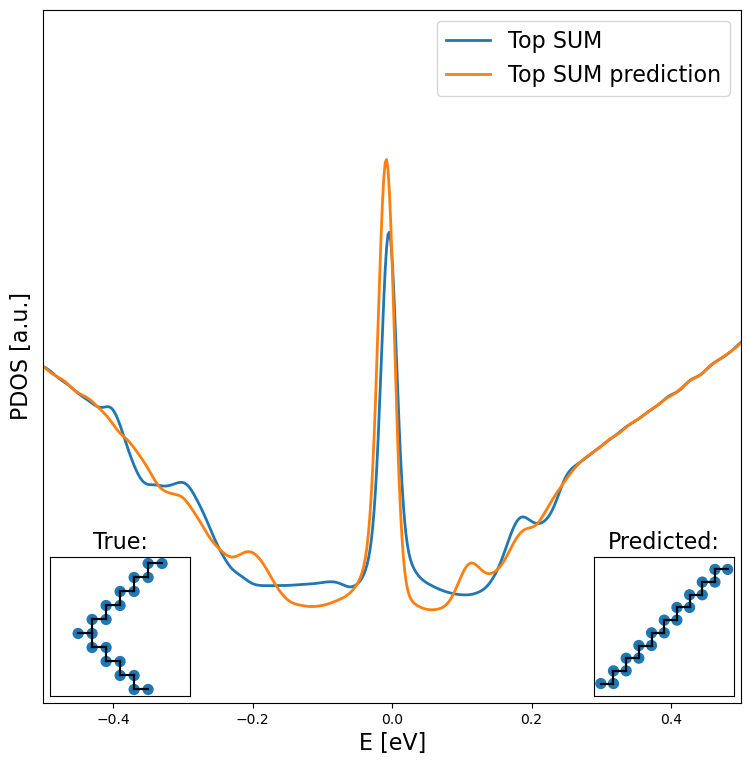

In [34]:
abra(directories[0],best_fits_list[0],True)

In [ ]:
for real,pred in zip(directories,best_fits_list):
    abra(real,pred)
    

# Layer dependance Tree model

In [ ]:
pdos_top_sum_cut_list = [pdos_top_sum[len(pdos_top_sum)//4:3*len(pdos_top_sum)//4] for pdos_top_sum in pdos_top_sum_list]

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])

In [ ]:
directories[129:141]

In [ ]:
directories_pred_dict = {}
for i,name in zip([132,135,141,150,172,206,288],['3','4','5','6','7','8','9']):
    pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:i]
    y_train = directories[129:i]

    clf = DecisionTreeClassifier().fit(pdos_top_sum_df_train,y_train)
    directories_pred = clf.predict(pdos_top_sum_df.iloc[:129])
    directories_pred_dict[name] = directories_pred

In [ ]:
len(directories_pred_dict['5'])

In [ ]:
pred_layer_dict = {}
for key in directories_pred_dict.keys():
    pred_layer_dict[key] = [int(directories_pred_dict[key][i].split('_')[0]) for i in range(len(directories_pred_dict[key]))]

In [ ]:
import plotly.figure_factory as ff


In [ ]:
pred_layer_all = array(list(pred_layer_dict.values())).flatten()

In [ ]:
pred_layer_all

In [ ]:
fig = ff.create_distplot(list(pred_layer_dict.values())+[pred_layer_all.tolist()], group_labels=list(pred_layer_dict.keys())+['all'],bin_size=0.5)

fig.show()


# 9 layers tree model

In [ ]:
pdos_top_sum_cut_list = [pdos_top_sum[len(pdos_top_sum)//4:3*len(pdos_top_sum)//4] for pdos_top_sum in pdos_top_sum_list]

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df.iloc[136:]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[136:]

### directories[136:]

In [ ]:
clf = DecisionTreeClassifier(random_state=42).fit(pdos_top_sum_df_train,y_train)

In [ ]:
'''
plt.figure(figsize = (30, 15))
title("Minden")
plot_tree(clf, max_depth=20, filled=True, 
          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),
          fontsize = 8, proportion = True,);
          '''

In [ ]:
directories_pred = clf.predict(pdos_top_sum_df)

In [ ]:
def abra(directory,directory_pred):
    i = directories.index(directory)
    i_pred = directories.index(directory_pred)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true: {directories[i]}")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred],faultok_list[i_pred])
    title(f"predicted: {directories[i_pred]}")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,directories_pred):
    abra(real,pred)
    

In [ ]:
'''
labels_by_hand = []
for real,pred in zip(directories,directories_pred):
    abra(real,pred)
    
    print(f'fosfasz')
    

    a = input()
    labels_by_hand.append(a)
    clear_output()
'''

In [ ]:
#matching_layers = labels_by_hand[:-3]

In [ ]:
matching_layers = load('matchin_layers.npy')

In [ ]:
matching_layers = array(matching_layers,dtype=int)

In [ ]:
save('matchin_layers',matching_layers)

In [ ]:
x, h = unique(matching_layers,return_counts=True)

In [ ]:
bar(x,h)

# 9 layers tree model top and bot

In [35]:
pdos_top_sum_cut_list = [pdos_top_sum[len(pdos_top_sum)//4:3*len(pdos_top_sum)//4] for pdos_top_sum in pdos_top_sum_list]
pdos_bot_sum_cut_list = [pdos_bot_sum[len(pdos_bot_sum)//4:3*len(pdos_bot_sum)//4] for pdos_bot_sum in pdos_bot_sum_list]

In [36]:
vstack((pdos_top_sum_cut_list,pdos_bot_sum_cut_list))

array([[33659.45670197, 33558.57439314, 33450.10768163, ...,
        36302.58937291, 36473.35656848, 36642.05865568],
       [33686.9776822 , 33566.62999757, 33436.91206217, ...,
        36373.78148873, 36531.1073559 , 36678.97415851],
       [33582.14426154, 33482.62857936, 33356.98407267, ...,
        36498.30363196, 36634.46367163, 36746.98285362],
       ...,
       [33231.98992654, 33075.86727809, 32931.17489285, ...,
        36182.36645805, 36300.98453502, 36433.21816299],
       [33589.57127   , 33415.02345252, 33229.8369945 , ...,
        36357.07398773, 36451.44238454, 36545.94164226],
       [33600.90711315, 33426.80328115, 33265.03070842, ...,
        36279.48250716, 36478.71279847, 36672.86724776]])

In [37]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])
pdos_bot_sum_df = pd.DataFrame(data=pdos_bot_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])

In [38]:
pdos_top_sum_df_train = pd.concat((pdos_top_sum_df[136:],pdos_bot_sum_df[136:]),ignore_index=True)
pdos_top_sum_df_train.drop_duplicates()

,-0.500,-0.498,-0.496,-0.494,-0.492,-0.490,-0.488,-0.486,-0.484,-0.482,...,0.480,0.482,0.484,0.486,0.488,0.490,0.492,0.494,0.496,0.498
0,33845.075863,33653.018424,33464.794634,33289.828893,33136.726675,33011.741246,32917.395087,32851.630895,32807.794046,32775.565755,...,34874.278057,34871.190147,34897.518041,34963.503540,35075.375463,35234.931467,35439.693638,35683.496973,35957.313483,36250.134298
1,30097.531266,30014.026978,29932.544929,29854.538913,29781.865662,29716.020933,29657.280130,29603.950731,29551.964183,29495.003178,...,34996.575959,35163.484581,35349.749630,35551.011715,35761.337647,35973.931512,36181.921543,36379.075636,36560.337303,36722.147023
2,33543.558530,33366.171365,33195.089964,33035.869937,32892.509867,32766.905519,32658.479796,32564.057332,32478.073054,32393.184993,...,34860.724878,35007.596124,35198.937240,35429.272915,35688.715347,35964.198690,36241.067690,36504.743851,36742.221125,36943.240419
3,34331.552439,34187.955443,34082.706449,34016.317786,33984.290833,33977.993820,33986.236594,33997.218458,34000.446088,33988.244270,...,34993.196127,35166.062566,35363.136643,35578.963093,35806.251076,36036.564576,36261.053895,36471.215269,36659.684482,36821.047391
4,31935.151036,31858.200209,31782.400371,31702.086232,31613.018330,31512.935404,31401.526991,31279.903400,31149.819545,31012.980474,...,35159.922853,35258.440304,35374.725663,35509.998765,35663.622287,35833.158897,36014.661745,36203.186714,36393.456128,36580.544439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,34209.576817,34060.859194,33924.395604,33802.208409,33693.897070,33596.787033,33506.374972,33417.027257,33322.847235,33218.586667,...,35313.121326,35425.285769,35536.322956,35650.436309,35771.274490,35901.352767,36041.699980,36191.794526,36349.776135,36512.853345
326,34091.880314,33953.676909,33840.623491,33753.551542,33689.704191,33642.930699,33604.294153,33563.093617,33508.253278,33429.951037,...,35348.598463,35490.782161,35623.165523,35749.498898,35873.921110,36000.184878,36131.004625,36267.627695,36409.702604,36555.472967
327,33231.989927,33075.867278,32931.174893,32795.042527,32663.469891,32531.936579,32396.072717,32252.277996,32098.185428,31932.902002,...,35397.534828,35532.278225,35655.230255,35767.513741,35871.897608,35972.519804,36074.331232,36182.366458,36300.984535,36433.218163
328,33589.571270,33415.023453,33229.836995,33039.097937,32848.273161,32662.816447,32487.724438,32327.035915,32183.315979,32057.213777,...,35299.295771,35503.320844,35693.304327,35864.290164,36014.235712,36143.929637,36256.560693,36357.073988,36451.442385,36545.941642


In [39]:
pdos_top_bot_sum_df_train = pdos_top_sum_df_train.round(5).drop_duplicates()

In [40]:
pdos_top_bot_sum_df_train

,-0.500,-0.498,-0.496,-0.494,-0.492,-0.490,-0.488,-0.486,-0.484,-0.482,...,0.480,0.482,0.484,0.486,0.488,0.490,0.492,0.494,0.496,0.498
0,33845.07586,33653.01842,33464.79463,33289.82889,33136.72668,33011.74125,32917.39509,32851.63089,32807.79405,32775.56576,...,34874.27806,34871.19015,34897.51804,34963.50354,35075.37546,35234.93147,35439.69364,35683.49697,35957.31348,36250.13430
1,30097.53127,30014.02698,29932.54493,29854.53891,29781.86566,29716.02093,29657.28013,29603.95073,29551.96418,29495.00318,...,34996.57596,35163.48458,35349.74963,35551.01171,35761.33765,35973.93151,36181.92154,36379.07564,36560.33730,36722.14702
2,33543.55853,33366.17136,33195.08996,33035.86994,32892.50987,32766.90552,32658.47980,32564.05733,32478.07305,32393.18499,...,34860.72488,35007.59612,35198.93724,35429.27291,35688.71535,35964.19869,36241.06769,36504.74385,36742.22113,36943.24042
3,34331.55244,34187.95544,34082.70645,34016.31779,33984.29083,33977.99382,33986.23659,33997.21846,34000.44609,33988.24427,...,34993.19613,35166.06257,35363.13664,35578.96309,35806.25108,36036.56458,36261.05390,36471.21527,36659.68448,36821.04739
4,31935.15104,31858.20021,31782.40037,31702.08623,31613.01833,31512.93540,31401.52699,31279.90340,31149.81955,31012.98047,...,35159.92285,35258.44030,35374.72566,35509.99877,35663.62229,35833.15890,36014.66175,36203.18671,36393.45613,36580.54444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,34460.52185,34367.28075,34290.69447,34228.76348,34177.85654,34133.56714,34091.67965,34048.99933,34003.84292,33956.09116,...,35421.15425,35595.75478,35754.61100,35895.53703,36017.68714,36121.72193,36209.97458,36286.52307,36357.05570,36428.45094
323,34706.57733,34660.37154,34623.86563,34593.29843,34564.12483,34531.73458,34492.21162,34442.98907,34383.27647,34314.18826,...,35129.90930,35301.04788,35485.89047,35681.38737,35882.69875,36083.43953,36276.37392,36454.48645,36612.20843,36746.49225
324,34126.84195,34020.01102,33921.55289,33832.05303,33751.54805,33679.62324,33615.49829,33558.08189,33505.98414,33457.48743,...,35342.08847,35515.92449,35681.05062,35835.50981,35977.88171,36107.47397,36224.57265,36330.67854,36428.61876,36522.42526
326,34091.88031,33953.67691,33840.62349,33753.55154,33689.70419,33642.93070,33604.29415,33563.09362,33508.25328,33429.95104,...,35348.59846,35490.78216,35623.16552,35749.49890,35873.92111,36000.18488,36131.00462,36267.62770,36409.70260,36555.47297


In [41]:
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train_top = ['TOP_' + directory for directory in directories[136:]]
y_train_bot = ['BOT_' + directory for directory in directories[136:]]
y_train = y_train_top + y_train_bot

y_test_top = ['TOP_' + directory for directory in directories[:136]]
y_test_bot = ['BOT_' + directory for directory in directories[:136]]
y_test = y_test_top + y_test_bot

In [42]:
y_train = array(y_train)[pdos_top_bot_sum_df_train.index]

In [43]:
clf = DecisionTreeClassifier(random_state=69420).fit(pdos_top_bot_sum_df_train,y_train)

C:\Users\Jancsi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.



In [44]:
'''
plt.figure(figsize = (30, 15))
title("Minden")
plot_tree(clf, max_depth=20, filled=True, 
          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),
          fontsize = 8, proportion = True,);
          '''

'\nplt.figure(figsize = (30, 15))\ntitle("Minden")\nplot_tree(clf, max_depth=20, filled=True, \n          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),\n          fontsize = 8, proportion = True,);\n          '

In [45]:
pdos_test = pd.concat((pdos_top_sum_df[:136],pdos_bot_sum_df[:136]),ignore_index=True).round(5)
pdos_test

,-0.500,-0.498,-0.496,-0.494,-0.492,-0.490,-0.488,-0.486,-0.484,-0.482,...,0.480,0.482,0.484,0.486,0.488,0.490,0.492,0.494,0.496,0.498
0,33659.45670,33558.57439,33450.10768,33331.17912,33200.44811,33058.35145,32907.05325,32750.08742,32591.73357,32436.23007,...,35214.20271,35353.68900,35498.81520,35649.39743,35805.42621,35966.80074,36132.96821,36302.58937,36473.35657,36642.05866
1,33686.97768,33566.63000,33436.91206,33298.83799,33154.88294,33008.30995,32862.39480,32719.75519,32581.93741,32449.32242,...,35233.42962,35390.55549,35550.92247,35713.80164,35878.66591,36044.74549,36210.58248,36373.78149,36531.10736,36678.97416
2,33582.14426,33482.62858,33356.98407,33203.13817,33022.83720,32821.54860,32607.82642,32392.20438,32185.75059,31998.48066,...,35085.87806,35287.16339,35504.01782,35726.74153,35945.40010,36151.05242,36336.76395,36498.30363,36634.46367,36746.98285
3,34309.88651,34205.42305,34088.08475,33957.59884,33815.28248,33663.91985,33507.46228,33350.56134,33197.97462,33053.92122,...,35122.44146,35347.88022,35577.03384,35798.08072,36000.89771,36178.56470,36328.30572,36451.66958,36553.91132,36642.72213
4,31892.49418,31788.58261,31676.18748,31554.61125,31423.66464,31283.75384,31135.98082,30982.22787,30825.18593,30668.28054,...,35298.43197,35480.47636,35669.49495,35859.06708,36041.63427,36209.56133,36356.36226,36477.87860,36573.18006,36644.98249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,33388.69093,33256.30475,33110.97923,32949.30944,32769.97573,32574.02281,32364.89574,32148.20061,31931.16251,31721.78164,...,35109.30414,35290.90973,35486.82508,35689.79815,35892.10245,36086.61573,36267.76180,36432.13900,36578.72469,36708.64559
268,33495.95616,33401.21096,33298.47840,33181.39715,33045.71390,32889.92726,32715.46764,32526.39818,32328.70823,32129.33844,...,35259.94463,35434.34353,35606.14630,35771.38332,35927.56407,36073.76330,36210.41093,36338.90213,36461.16027,36579.26341
269,33540.11168,33418.73212,33282.52795,33130.46966,32963.57072,32784.92096,32599.46518,32413.49422,32233.85213,32066.93120,...,35070.64019,35235.13250,35419.86268,35619.04004,35825.53080,36031.81772,36230.97555,36417.49437,36587.81015,36740.46634
270,33549.11675,33437.83779,33336.29896,33243.79526,33158.27814,33076.14374,32992.41131,32901.35030,32797.47122,32676.66655,...,35225.93760,35394.58984,35563.68901,35731.53092,35897.17736,36060.08401,36219.67805,36375.04959,36524.86710,36667.54348


In [46]:
directories_pred_abs = clf.predict(pdos_test)

C:\Users\Jancsi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.



In [118]:
directories_pred = clf.predict_proba(pdos_test)

C:\Users\Jancsi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.



In [123]:
directories_pred_abs[16], argmax(directories_pred[16]), y_train[180]

("TOP_9_faults_conv_720_['1b', '2b', '4b', '8b']",
 180,
 "BOT_7_faults_conv_720_['2b', '4b']")

In [ ]:
def abra(directory,directory_pred_proba):
    layer = directory[:4]
    directory_pred = array(y_train)[where(directory_pred_proba != 0)[0]]
    layer_pred = [dir_pred[:4] for dir_pred in directory_pred]
    print(where(directory_pred_proba != 0)[0])
    print(layer_pred)
    i = directories.index(directory[4:])
    print(i)
    i_pred = [directories.index(dir_pred[4:]) for dir_pred in directory_pred]
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label=f'{layer} SUM',lw=2)
    if 'TOP_' in layer_pred:
        plot(E,pdos_top_sum_list[i_pred[0]],label=f'Top SUM prediction',lw=2)
    if 'BOT_' in layer_pred:
        plot(E,pdos_bot_sum_list[i_pred[0]],label=f'Bot SUM prediction',lw=2)
    
    legend(loc='upper right',fontsize=13)
    xlabel('E [eV]',fontsize=13)
    ylim(-1e4,8e4)
    xlim(-0.5,0.5)
    yticks([],[])
    ylabel('D(E) [a.u.]',fontsize=13)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:",fontsize=13)
    for i_p,l in zip(i_pred,[4,7][:len(i_pred)]):
        insax = inset_axes(ax, 
                        width="20%", # width = 30% of parent_bbox
                        height="20%", # height : 1 inch
                        loc=l)
        _ = chain_maker(N_list[i_p],faultok_list[i_p])
        title(f"predicted:",fontsize=13)
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
31
def abra_jatszos(directory,directory_pred_proba):
    layer = directory[:4]
    directory_pred = array(y_train)[where(directory_pred_proba != 0)[0]]
    print(where(directory_pred_proba != 0)[0])
    layer_pred = [dir_pred[:4] for dir_pred in directory_pred]
    print(layer_pred)
    i = directories.index(directory[4:])
    print(i)
    i_pred = [directories.index(dir_pred[4:]) for dir_pred in directory_pred]
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_bot_sum_list[i],label=f'Top SUM',lw=2)
    plot(E,pdos_bot_sum_list[i_pred[0]],label=f'{layer_pred} SUM prediction',lw=2)
    legend(loc='upper right',fontsize=13)
    xlabel('E [eV]',fontsize=13)
    ylim(-1e4,8e4)
    xlim(-0.5,0.5)
    yticks([],[])
    ylabel('D(E) [a.u.]',fontsize=13)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:",fontsize=13)
    for i_p,l in zip(i_pred,[4,7][:len(i_pred)]):
        insax = inset_axes(ax, 
                        width="20%", # width = 30% of parent_bbox
                        height="20%", # height : 1 inch
                        loc=l)
        _ = chain_maker(N_list[i_p],faultok_list[i_p])
        title(f"predicted:",fontsize=13)
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()
    
abra_jatszos(y_test[16],directories_pred[16])

In [27]:
directories[0],y_train[0]

("10_faults_conv_720_['1b', '2b', '3b', '4b']", 'TOP_2_faults_conv_720_[]')

In [28]:
for real,pred in zip(y_test,directories_pred):
    abra(real,pred)
    

NameError: name 'abra' is not defined

In [ ]:
'''
labels_by_hand = []
for real,pred in zip(y_test,directories_pred):
    abra(real,pred)
    
    a = input()
    labels_by_hand.append(a)
    clear_output()
'''

In [ ]:
len(y_test)/2

In [ ]:
16, 101

In [ ]:
10+136,27+136,67+136

In [ ]:
abra(y_test[0],directories_pred[0])

In [ ]:
'TOP' == 'TOP'

In [57]:
def abra(directory,directory_pred,save=False):
    layer = directory[:3]
    layer_pred = directory_pred[:3]
    i = directories.index(directory[4:])
    i_pred = directories.index(directory_pred[4:])
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    
    if layer == 'TOP':
        plot(E,pdos_top_sum_list[i],label='Top SUM',lw=2)
    else:
        plot(E,pdos_bot_sum_list[i],label='Bot SUM',lw=2)
    if layer_pred == 'TOP':
        plot(E,pdos_top_sum_list[i_pred],label='Top SUM prediction',lw=2)
    else:
        plot(E,pdos_bot_sum_list[i_pred],label='Bot SUM prediction',lw=2)
    legend(loc='upper right',fontsize=16)
    xlabel('E [eV]',fontsize=16)
    ylim(-1e4,7e4)
    xlim(-0.5,0.5)
    yticks([],[])
    ylabel('PDOS [a.u.]',fontsize=13)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:",fontsize=16)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred],faultok_list[i_pred])
    title(f"predicted:",fontsize=16)
    if save == True:
        savefig(f'{directory}_pred.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
for real,pred in zip(y_test,directories_pred_abs):
    abra(real,pred)
    

In [ ]:
'''
labels_by_hand = []
for real,pred in zip(y_test,directories_pred_abs):
    abra(real,pred)
    
    print(f'fosfasz')
    

    a = input()
    labels_by_hand.append(a)
    clear_output()
'''

In [ ]:
directories_pred_abs[16]

In [ ]:
#163, 16 példának

In [ ]:
#matching_layers = labels_by_hand

In [ ]:
#save('matchin_layers_up_down',matching_layers)

In [54]:
conf_preds = array(load('matchin_layers_up_down.npy'),dtype=int)
conf_preds

array([9, 9, 5, 8, 5, 9, 9, 7, 5, 9, 5, 8, 9, 9, 9, 8, 7, 6, 7, 8, 8, 9,
       8, 3, 7, 6, 9, 9, 7, 6, 5, 8, 9, 9, 8, 6, 5, 6, 6, 9, 9, 7, 7, 8,
       7, 8, 8, 9, 6, 9, 6, 8, 8, 6, 4, 8, 9, 8, 6, 6, 9, 5, 9, 9, 7, 8,
       8, 8, 8, 8, 7, 8, 9, 6, 9, 6, 9, 5, 9, 9, 9, 7, 5, 8, 9, 9, 5, 9,
       8, 8, 8, 9, 8, 9, 6, 9, 8, 6, 8, 8, 6, 5, 8, 8, 8, 9, 9, 7, 9, 8,
       9, 6, 7, 7, 8, 8, 7, 6, 4, 7, 9, 9, 5, 8, 7, 6, 7, 7, 9, 9, 6, 4,
       7, 8, 9, 9, 6, 9, 8, 6, 5, 9, 9, 9, 4, 6, 4, 9, 9, 5, 8, 9, 6, 8,
       8, 8, 9, 7, 4, 4, 4, 6, 5, 8, 2, 9, 8, 3, 9, 9, 5, 7, 9, 7, 8, 7,
       9, 6, 4, 6, 5, 8, 5, 7, 8, 7, 9, 6, 9, 5, 8, 9, 6, 8, 4, 6, 8, 8,
       9, 3, 9, 9, 8, 8, 9, 7, 7, 7, 8, 5, 5, 9, 6, 6, 9, 9, 9, 9, 8, 9,
       9, 4, 7, 6, 9, 6, 9, 7, 7, 9, 7, 8, 5, 7, 6, 8, 9, 8, 8, 7, 7, 8,
       3, 6, 8, 5, 9, 8, 5, 6, 5, 8, 9, 4, 7, 8, 9, 5, 9, 6, 8, 6, 6, 9,
       9, 5, 6, 7, 7, 6, 9, 9])

In [37]:
where(conf_preds == 2)

(array([164], dtype=int64),)

In [ ]:
where

3
TOP_10_faults_conv_720_['1b', '2b', '3b', '7b']


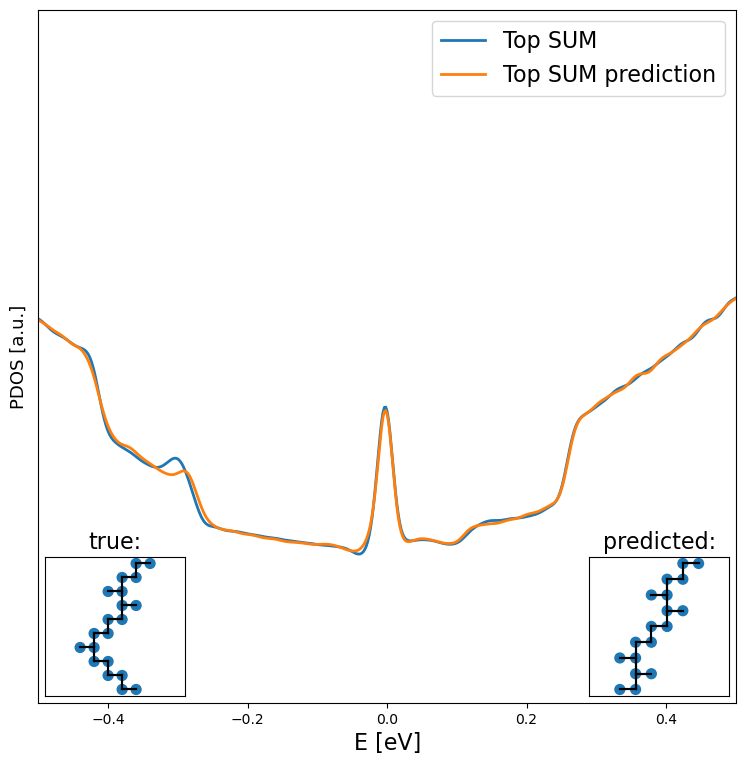

In [60]:
abra(y_test[3],directories_pred_abs[3],True)



In [55]:
x, h = unique(conf_preds,return_counts=True)

In [56]:
len(load('matchin_layers_up_down.npy'))

272

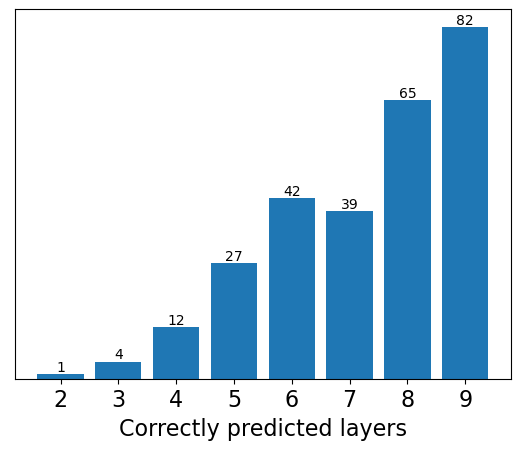

In [61]:
bar1 = bar(x,h)
yticks([],[])
xlabel('Correctly predicted layers', fontsize=16)
xticks([2,3,4,5,6,7,8,9],[2,3,4,5,6,7,8,9], fontsize=16)
bar_label(bar1,labels=h,)
savefig('layerspredicted.pdf', bbox_inches='tight')
show()

In [ ]:
#save('matchin_layers_up_down',labels_by_hand)

In [126]:
median(conf_preds),mean(conf_preds)

(8.0, 7.279411764705882)

In [ ]:
len(labels_by_hand)

# Half range Correlation all with 9

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])
pdos_top_sum_df_train = pdos_top_sum_df.iloc[129:]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:]

In [ ]:
corr_mat = zeros([len(pdos_top_sum_df.values),len(pdos_top_sum_df_train.values)])
for i,pdos_test in enumerate(pdos_top_sum_df.values):
    for j,pdos_train in enumerate(pdos_top_sum_df_train.values):
        corr_mat[i,j] = correlate(pdos_test,pdos_train)

In [ ]:
best_fits_list = [argsort(line)[::-1][:3] for line in corr_mat] 

In [ ]:
def abra(directory,i_pred):
    i = directories.index(directory)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[129:][i_pred[0]],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[129:][i_pred[0]],faultok_list[129:][i_pred[0]])
    title(f"best predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="center right")
    _ = chain_maker(N_list[129:][i_pred[1]],faultok_list[129:][i_pred[1]])
    title(f"second predicted:")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="upper right")
    _ = chain_maker(N_list[129:][i_pred[2]],faultok_list[129:][i_pred[2]])
    title(f"third predicted:")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,best_fits_list):
    abra(real,pred)
    

In [ ]:
chain_maker(6,['2b','4b'])

# 1 fault place

In [ ]:
minus_E_peak = [307,328,346,361,373,383,390,397]
mid_E_peak = [503,500,499,498,497,497,496,496]
plust_E_peak = [625,611,599,588,579,570,563,557]

In [ ]:
hibatlan_list = [fault for fault in faultok_list if len(fault)==1]

In [ ]:
chain_maker(10,['1b'])
show()
chain_maker(10,['6b'])


In [ ]:
egyhibak_list = [fault for fault in faultok_list[:129] if len(fault)==1]

In [ ]:
egyhibak_list = [egyhibak_list[-1]] + egyhibak_list[:-1]

In [ ]:
fig = plt.figure(figsize=(5, 9),facecolor='white')
for j,hiba in enumerate(egyhibak_list):
    i = faultok_list[:129].index(hiba)
    plot(E,2*pdos_top_sum_list[i]+j*max(pdos_top_sum_list[i]),label=f'top_{hiba}')
    
for j,hiba in enumerate(egyhibak_list[1:-1][::-1]):
    i = faultok_list[:129].index(hiba)
    plot(E,2*pdos_bot_sum_list[i]+(j+6)*max(pdos_top_sum_list[i]),label=f'bot_{hiba}')
    
    

legend(loc='upper right')
xlabel('E [eV]')
xlim(-0.5,0.5)
#ylim(-1e4,8e4)
yticks([]) 

# With PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pdos_top_sum_PCA_reverse_df = pca.inverse_transform(pdos_top_sum_PCA_df)

In [ ]:
pdos_top_sum_cut_list = [pdos_top_sum[len(pdos_top_sum)//4:3*len(pdos_top_sum)//4] for pdos_top_sum in pdos_top_sum_list]

In [ ]:
pdos_top_sum_df = pd.DataFrame(data=pdos_top_sum_cut_list,columns=E[len(E)//4:3*len(E)//4])

In [ ]:
pca = PCA(n_components=1)
pdos_top_sum_df = pca.fit_transform(pdos_top_sum_df)

In [ ]:
pdos_top_sum_df_train = pdos_top_sum_df[129:]
#pdos_top_sum_df_train['y'] = directories[129:141]
#pdos_top_sum_df_train = pd.get_dummies(pdos_top_sum_df_train,columns=['y'])
y_train = directories[129:]

In [ ]:
clf = DecisionTreeClassifier().fit(pdos_top_sum_df_train,y_train)

In [ ]:
'''
plt.figure(figsize = (30, 15))
title("Minden")
plot_tree(clf, max_depth=20, filled=True, 
          feature_names=pdos_top_sum_df_train.columns, class_names=sorted(y_train),
          fontsize = 8, proportion = True,);
          '''

In [ ]:
directories_pred = clf.predict(pdos_top_sum_df)

In [ ]:
def abra(directory,directory_pred):
    i = directories.index(directory)
    i_pred = directories.index(directory_pred)
    print(i)
    print(directory)
    fig = plt.figure(figsize=(9, 9),facecolor='white')
    ax = fig.add_subplot(111)
    plot(E,pdos_top_sum_list[i],label='Top-SUM')
    plot(E,pdos_top_sum_list[i_pred],label='Top-SUM_pred')
    grid()
    title(f'{directory}')
    legend(loc='upper right')
    xlabel('E [eV]')
    ylim(-1e4,8e4)
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower left")
    _ = chain_maker(N_list[i],faultok_list[i])
    title(f"true: {directories[i]}")
    insax = inset_axes(ax, 
                    width="20%", # width = 30% of parent_bbox
                    height="20%", # height : 1 inch
                    loc="lower right")
    _ = chain_maker(N_list[i_pred],faultok_list[i_pred])
    title(f"predicted: {directories[i_pred]}")
    #savefig(f'predictions_4layers//{directories[i]}')
    plt.show()

In [ ]:
for real,pred in zip(directories,directories_pred):
    abra(real,pred)
    